In [1]:
import glob
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
import rasterio
import rasterio.plot
import shapely
import skimage

In [90]:
DATA_PATH = '/data/microsoft_planetary_computer/outputs/preprocessed/'
EPSG = 'epsg-32618'
LOCATION = 'duck'
LC_TYPE = 'chesapeake_bay_swin_crossentropy_lc_naip'
RESOLUTION = 10.0
water_index = 0
# oem: big bear lake, kentucky river, duck
# cb: big bear lake, kentucky river, duck, castaic lake

# castaic lake - naip, 57.47599085746225
# big_bear_lake - planet, 1050.5703125
# colorado river - No correction
# kentucky river - planet, 1324.0589079436945
# duck = planet, 411.9718089421824


In [91]:
lc = os.path.join(DATA_PATH, '{}/{}/{}/{}/mosaic.tiff'.format(EPSG, LOCATION, LC_TYPE, RESOLUTION))
naip = os.path.join(DATA_PATH, '{}/{}/{}/{}/mosaic.tiff'.format(EPSG, LOCATION, 'naip', RESOLUTION))
planet = os.path.join(DATA_PATH, '{}/{}/{}/{}/mosaic.tiff'.format(EPSG, LOCATION, 'planet', RESOLUTION))
dw = os.path.join(DATA_PATH, '{}/{}/{}/{}/mosaic.tiff'.format(EPSG, LOCATION, 'dynamicworld', RESOLUTION))

corrected_lc_dir = os.path.join(DATA_PATH, '{}/{}/{}/{}'.format(EPSG, LOCATION, '{}_corrected'.format(LC_TYPE), RESOLUTION))

In [92]:
with rasterio.open(lc, 'r') as src:
    lc_data = src.read()
    target_profile = src.profile
    target_bounds = src.bounds
    target_polygon = shapely.geometry.box(*src.bounds)
    target_crs = src.crs
    epsg_code = target_crs.to_epsg()
    target_res = src.res

with rasterio.open(naip, 'r') as src:
    naip_data = src.read()

with rasterio.open(planet, 'r') as src:
    planet_data = src.read()

with rasterio.open(dw, 'r') as src:
    dw_data = src.read()


411.9718089421824


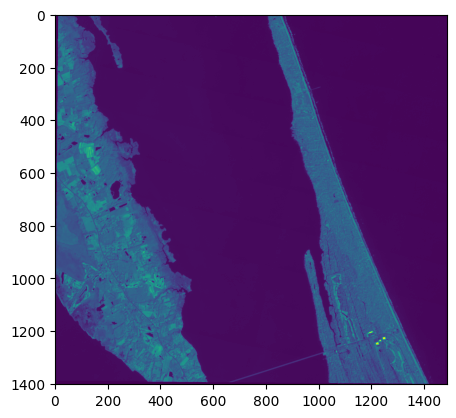

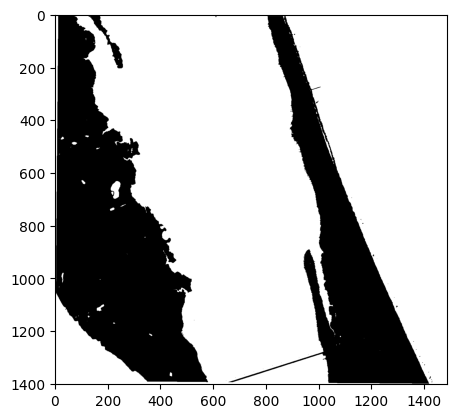

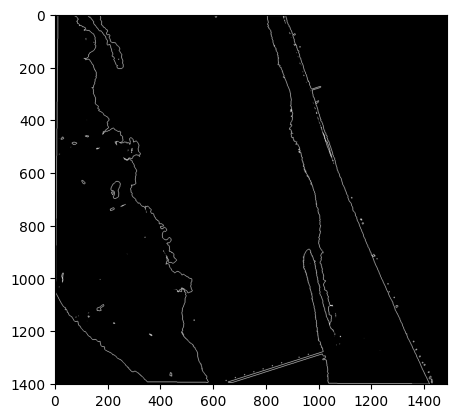

<Axes: >

In [96]:
ir = planet_data[-1]
# fig = go.Figure()
# fig.add_trace(go.Histogram(
#     x=ir.ravel(),
#     xbins=dict( # bins used for histogram
#         start=0,
#         end=10000,
#         size=50
#     ),
#     marker_color='#EB89B5',
#     opacity=0.75
# ))
# fig.show()
dw_data_vals = cv2.resize(dw_data[-1], (ir.shape[1], ir.shape[0]), interpolation=cv2.INTER_NEAREST)
water_idx = dw_data_vals == 0
# water_idx[400:700, 500:1500] = 0
# water_idx[700:1000, 750:1200] = 0
# water_idx[200:400, 275:325] = 0

ir_guided_water_vals = ir[water_idx]
# fig = go.Figure()
# fig.add_trace(go.Histogram(
#     x=ir_guided_water_vals.ravel(),
#     xbins=dict( # bins used for histogram
#         start=0,
#         end=10000,
#         size=50
#     ),
#     marker_color='#EB89B5',
#     opacity=0.75
# ))
# fig.show()

water_thresh_val = ir_guided_water_vals.mean() + 1*ir_guided_water_vals.std()
print(water_thresh_val)
masked = ir < water_thresh_val


# masked = dw_data_vals == 0

eroded_mask = skimage.morphology.binary_erosion(masked, skimage.morphology.disk(2))
rasterio.plot.show(ir)
rasterio.plot.show(masked, cmap='gray')
rasterio.plot.show(masked ^ eroded_mask, cmap='gray')

In [108]:

os.makedirs(corrected_lc_dir, exist_ok=True)
corrected_path = os.path.join(corrected_lc_dir, 'mosaic.tiff')

with rasterio.open(lc, 'r') as src:
    lc_data = src.read()
    C, H, W = lc_data.shape
    eroded_mask = cv2.resize(eroded_mask.astype(np.uint8), (W, H), interpolation=cv2.INTER_NEAREST)
    
    lc_profile = src.profile.copy()
    print(lc_data.shape, eroded_mask.shape)

    raw_lc = np.log(lc_data[:-1, :, :] + 1e-8)
    raw_lc[water_index, eroded_mask == 1] = 0.5
    softmax_lc = np.exp(raw_lc) / np.sum(np.exp(raw_lc), axis=0)
    lc_data[:-1, :, :] = softmax_lc
    lc_data[-1, :, :] = np.argmax(softmax_lc, axis=0)
    
    # with rasterio.open(corrected_path, 'w', **lc_profile) as dst:
    #     dst.write(lc_data)
    


(8, 1402, 1487) (1402, 1487)


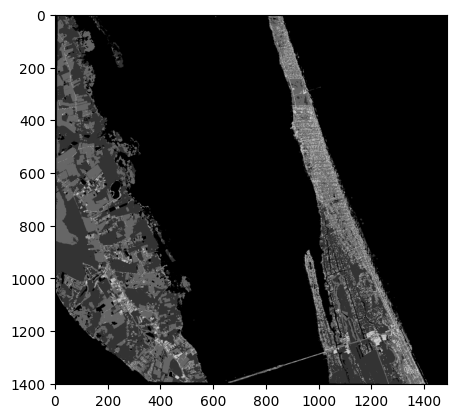

<Axes: >

In [109]:
rasterio.plot.show(lc_data[-1], cmap='gray')